# JSC 270 Lab 8
# Evaluating Classification Performance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import *
import numpy as np
import seaborn as sns

### Read in [our data](https://drive.google.com/file/d/1QAWVV9q3h1eHoMNgTfqPy2Z5TmXnGaRB/view?usp=sharing)

In [ ]:
# Read in data from github 
!wget "https://raw.githubusercontent.com/jlgrons/JSC270_Lab8/master/JSC270_Lab8data_20210323.csv"

--2022-03-16 13:19:54--  https://raw.githubusercontent.com/jlgrons/JSC270_Lab8/master/JSC270_Lab8data_20210323.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109115 (107K) [text/plain]
Saving to: ‘JSC270_Lab8data_20210323.csv’

JSC270_Lab8data_202 100%[===================>] 106.56K  --.-KB/s    in 0.03s   

2022-03-16 13:19:54 (3.96 MB/s) - ‘JSC270_Lab8data_20210323.csv’ saved [109115/109115]



In [ ]:
as_data = pd.read_csv(r'JSC270_Lab8data_20210323.csv', encoding= 'latin1')
as_data.head()

,fev1_z,asthma,sev_asthma,pred_fev1_z,asthma_pred,sev_asthma_pred,age,lang_at_home,sex,income
0,-1.207066,0,1,-0.380462,0.706606,0.193648,15.100756,english,F,high
1,0.277429,1,1,0.888451,0.787937,0.356634,6.389002,english,F,high
2,1.084441,1,1,1.625245,0.384394,0.924491,9.149318,english,M,high
3,-2.345698,0,0,-4.299877,0.017826,0.171789,13.340099,mandarin,M,low
4,0.429125,1,1,0.799398,0.611069,0.954608,19.076183,english,F,high


In [ ]:
as_data.shape

(1000, 10)

Suppose you are asked to create a tool that can help doctors decide whether to treat an individual for asthma by using the sound of someone blowing on their phone mic and returning: (1) the probability of asthma, (2) the probability of severe asthma, and (3) lung function (as measured by normalized forced experatory volume in 1 second, FEV1). This dataset is a simulated representation of the validation dataset you would have after modeling using an independent training dataset collected from patients who are seen in a respirology clinic.  

This data simulates the output from 3 models: 

- a continuous outcome model (pred_fev1_z)
- an unbalanced data-set classifier (sev_asthma_pred)
- a balanced data-set classifier (asthma_pred)
 
The true labels for these models are: 

- fev1_z
- asthma
- sev_asthma



###Let's do some basic exploration of this data:
- histograms
- barplots
- scatterplots

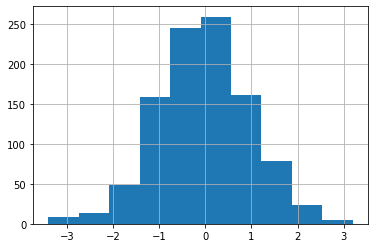

In [ ]:
## FEV1
as_data.fev1_z.hist()
plt.show()

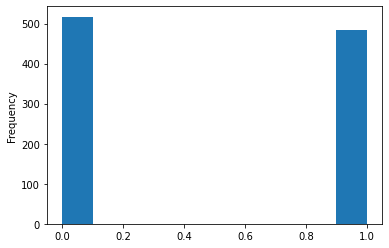

In [ ]:
## Asthma
as_data.asthma.plot.hist()
plt.show()

This isn't quite right. Let's recode this variable so we see a categorical plot.

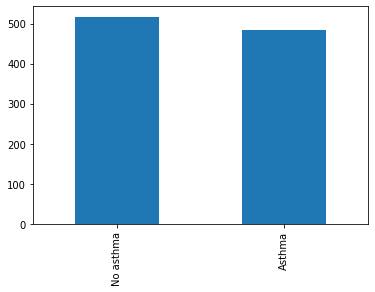

In [ ]:
as_data['asthma_cat'] = np.where(as_data['asthma'] == 1, "Asthma", "No asthma")

as_data.asthma_cat.value_counts().plot(kind="bar")
plt.show()

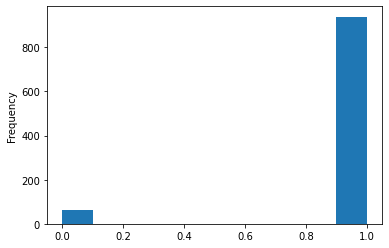

In [ ]:
## Severe Asthma
as_data.sev_asthma.plot.hist()
plt.show()
# We have the same issue!

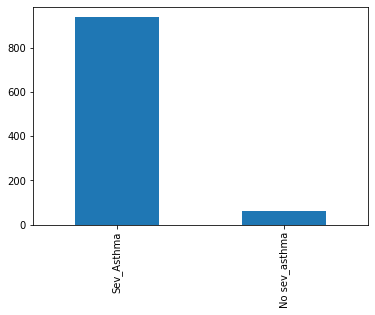

In [ ]:
as_data['sev_asthma_cat'] = np.where(as_data['sev_asthma'] == 1, "Sev_Asthma", "No sev_asthma")

as_data.sev_asthma_cat.value_counts().plot(kind="bar")
plt.show()

#### Q: How do the asthma and severe outcomes compare?  Which would be harder to build a classifier for?


#### Q: How do the FEV1 scores compare in those with asthma vs those without asthma?

### Now, let's compute some basic performance metrics for your tool focusing on the binary asthma outcome.

### Recall your confusion matrix: 

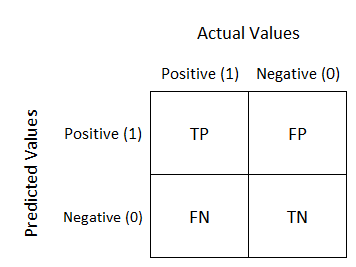

####Asthma classifier
- Area under the receiver-operator curve (AUROC): FPR vs TPR
    - Sensitivity = True Positive Rate = TP/(TP + FN)
    - Specificity = TN/(TN + FP) = 1 - FP/(TN + FP) = 1 - FPR
    - False Postive Rate (FPR) = FP/(TN + FP) 

- Area under the precision-recall curve (AUPRC): Precision vs Recall
    - Precision = TP/(TP + FP)
    - Recall = TP/(TP + FN) = Sensitivity

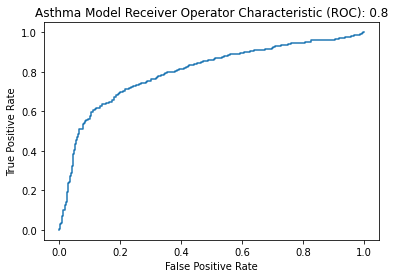

In [ ]:
## AUROC
fpr, tpr, thresholds = roc_curve(as_data.asthma.to_numpy(), as_data.asthma_pred.to_numpy(), 
                                 pos_label = 1)

asthma_auroc = roc_auc_score(as_data.asthma.to_numpy(), as_data.asthma_pred.to_numpy())

plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Asthma Model Receiver Operator Characteristic (ROC): ' + str(round(asthma_auroc,3)))
plt.show()


#### What is the range of AUC?  What is the shape of a perfect ROC curve?

In [ ]:
### AUC ranges from 0 and 1, with 0.5 indicating "random guessing"
### A perfect ROC curve is a right angle that starts at (0,0), turns right at (0,1), and ends at (1,1)

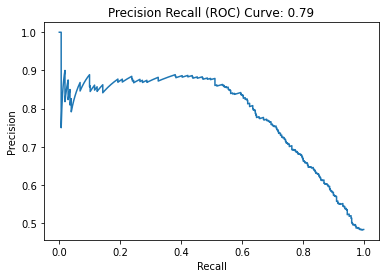

In [ ]:
### AUPRC
precision, recall, thresholds_pr = precision_recall_curve(as_data.asthma.to_numpy(), as_data.asthma_pred.to_numpy(), pos_label = 1)

asthma_auprc = average_precision_score(as_data.asthma.to_numpy(), as_data.asthma_pred.to_numpy())

plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision Recall (ROC) Curve: ' + str(round(asthma_auprc, 2)))
plt.show()

# Alternative way to display the plot
# pr_display = PrecisionRecallDisplay(precision=precision,recall=recall,average_precision=asthma_auprc,estimator_name='AUPRC').plot()

#### Q: Is precision a monotonic function of recall?

Now, let's look at specific thresholds to evaluate: 
- accuracy
- true positives (TP), false positives (FP), true negatives (TN), false negatives (FN)
- sensitivity (recall)
- specificity
- precision

([all metrics here](https://scikit-learn.org/stable/modules/model_evaluation.html))

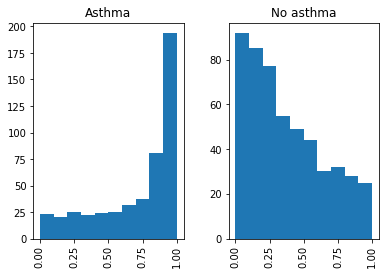

In [ ]:
# plot the predictions by asthma 
as_data.asthma_pred.hist(by=as_data['asthma_cat'])
plt.show()

In [ ]:
as_threshold = 0.5 # standard threshold

as_dich_pred = (as_data.asthma_pred.to_numpy() > as_threshold).astype(int)
as_dich_true = as_data.asthma.to_numpy()

## accuracy
as_acc = accuracy_score(as_dich_true, as_dich_pred)

## confusion matrix
c_mat = confusion_matrix(as_dich_true, as_dich_pred)

TN, FP, FN, TP = c_mat.ravel()

print("Asthma model")
print("Accuracy: " + str(round(as_acc, 2)))
print("True positives: " + str(round(TP)))
print("True negatives: " + str(round(TN)))
print("False positives: " + str(round(FP)))
print("False negatives: " + str(round(FN)))

print("Confusion matrix")
print(c_mat)

Asthma model
Accuracy: 0.73
True positives: 369
True negatives: 358
False positives: 159
False negatives: 114
Confusion matrix
[[358 159]
 [114 369]]


In [ ]:
## Compute metrics
as_sens = TP/(TP + FN)
as_spec = TN/(TN + FP)
as_prec = TP/(TP + FP)

print("Sensitivity (Recall): " + str(round(as_sens, 2)))
print("Specificity: " + str(round(as_spec, 2)))
print("Precision: " + str(round(as_prec, 2)))

Sensitivity (Recall): 0.76
Specificity: 0.69
Precision: 0.7


#### Q: What happens when you change the threshold to 0.2? What about 0.8?  Why does this happen?

### Now, how might we evaluate safety for the asthma classifier? 

Consider the context of the problem. If the algorithm started to be used tomorrow, how might people be made unsafe? What metric(s) could you use to assess this? What evidence would you need to call the algorithm "safe"?

Scenario 1 - A positive test results in a patient being medicated (with an inhaler) and a negative test results in continued surveillance. 

  - FP risk: Low, inexpensive, patient takes home inhaler they may not need ; would need to consider safety of a patient without asthma using an inhaler (e.g. side-effects of the inhaler) 

  - FN risk: High, potential adverse outcomes for asthmatic patient (ie. untreated asthma attack) 

  - Which metric(s) should we maximize? 
  




Scenario 2 - Now suppose a negative test results in a patient no longer being surveilled and a positive test results in continued surveillance (with or without medication)

  - FP risk: V. low: just receive standard of care 

  - FN risk: VERY HIGH

  - Which metric(s) should we maximize? 



###Let's use the code above to explore these senarios

In [ ]:
# Scenario 1: Find the threshold that gives TPR above 0.90
threshold = thresholds[np.where(tpr > 0.9)[0][0]]
print("New threshold = " + str(round(threshold,2)))

New threshold = 0.23


In [ ]:
as_threshold = threshold

as_dich_pred = (as_data.asthma_pred.to_numpy() > as_threshold).astype(int)
as_dich_true = as_data.asthma.to_numpy()

## accuracy
as_acc = accuracy_score(as_dich_true, as_dich_pred)

## confusion matrix
c_mat = confusion_matrix(as_dich_true, as_dich_pred)

TN, FP, FN, TP = c_mat.ravel()

## Compute metrics
as_sens = TP/(TP + FN)
as_spec = TN/(TN + FP)
as_prec = TP/(TP + FP)

print("Sensitivity (Recall): " + str(round(as_sens, 2)))
print("Specificity: " + str(round(as_spec, 2)))
print("Precision: " + str(round(as_prec, 2)))

Sensitivity (Recall): 0.9
Specificity: 0.39
Precision: 0.58


In [ ]:
# Scenario 2: Find the threshold that gives TPR above 0.95 
threshold = thresholds[np.where(tpr > 0.95 )[0][0]]
print("New threshold = " + str(round(threshold,2)))

New threshold = 0.11


In [ ]:
as_threshold = threshold

as_dich_pred = (as_data.asthma_pred.to_numpy() > as_threshold).astype(int)
as_dich_true = as_data.asthma.to_numpy()

## accuracy
as_acc = accuracy_score(as_dich_true, as_dich_pred)

## confusion matrix
c_mat = confusion_matrix(as_dich_true, as_dich_pred)

TN, FP, FN, TP = c_mat.ravel()

## Compute metrics
as_sens = TP/(TP + FN)
as_spec = TN/(TN + FP)
as_prec = TP/(TP + FP)

print("Sensitivity (Recall): " + str(round(as_sens, 2)))
print("Specificity: " + str(round(as_spec, 2)))
print("Precision: " + str(round(as_prec, 2)))

Sensitivity (Recall): 0.95
Specificity: 0.19
Precision: 0.52


#### Q: Now, how would you test for safety? That is, how would you test that your model has an acceptable false negative rate?




In [ ]:
# Let's get a confidence interval using our threshold for 0.95 TPR
my_threshold = threshold

def get_as_fnr_pval(thresh, n_it=1000):
  fnr = []

  ### Get point estimate
  as_dich_pred = (as_data.asthma_pred.to_numpy() > thresh).astype(int)
  as_dich_true = as_data.asthma.to_numpy()

  c_mat = confusion_matrix(as_dich_true, as_dich_pred)
  TN, FP, FN, TP = c_mat.ravel()

  true_fnr = FN/(TP + FN)

  ### Get bootstrapped confidence interval - no need to worry about the details here
  for i in range(n_it):
    new_samp = as_data.sample(n = as_data.shape[0], replace=True, random_state=i)

    as_dich_pred = (new_samp.asthma_pred.to_numpy() > thresh).astype(int)
    as_dich_true = new_samp.asthma.to_numpy()

    c_mat = confusion_matrix(as_dich_true, as_dich_pred)
    TN, FP, FN, TP = c_mat.ravel()

    fnr.append(FN/(TP + FN))


  sorted_fnr = np.array(sorted(fnr))

  lcl = np.percentile(sorted_fnr,0)
  ucl = np.percentile(sorted_fnr,95)

  out_dict = {"FNR": true_fnr, 
              "lcl": lcl, 
              "ucl": ucl}

  return(out_dict)

get_as_fnr_pval(thresh=my_threshold)

{'FNR': 0.049689440993788817,
 'lcl': 0.02301255230125523,
 'ucl': 0.06598531642230672}

### How might we evaluate bias?

Again, you'll need to consider the context of each problem. 

What metric(s) should we use to assess bias? What evidence would you need to call the algorithm "unbiased"? 

In [ ]:
# Let's assess performance across sex (defined as M/F in this dataset)
# We could look across other demographics as well

my_threshold = threshold

def get_split_as_fnr_pval(thresh, split_var="sex", n_it=1000):
  fnr = []
  out_dict = {}

  data_split = as_data.groupby(as_data[split_var])
  split_vals = as_data[split_var].unique().tolist()

  for my_var in split_vals:     
    data = data_split.get_group(my_var)
    
    ### Get point estimate
    as_dich_pred = (data.asthma_pred.to_numpy() > thresh).astype(int)
    as_dich_true = data.asthma.to_numpy()
    c_mat = confusion_matrix(as_dich_true, as_dich_pred)
    TN, FP, FN, TP = c_mat.ravel()
    true_fnr = FN/(TP + FN)

    ### Get bootstrapped confidence interval 
    for i in range(n_it):
      new_samp = data.sample(n = data.shape[0], replace=True, random_state=i)
      as_dich_pred = (new_samp.asthma_pred.to_numpy() > thresh).astype(int)
      as_dich_true = new_samp.asthma.to_numpy()
      c_mat = confusion_matrix(as_dich_true, as_dich_pred)
      TN, FP, FN, TP = c_mat.ravel()
      fnr.append(FN/(TP + FN))
    
    sorted_fnr = np.array(sorted(fnr))
    lcl = np.percentile(sorted_fnr,2.5)
    ucl = np.percentile(sorted_fnr,97.5)
    
    out_dict.update({my_var: {"FNR": true_fnr, 
                "lcl": lcl, 
                "ucl": ucl}})

  return(out_dict)

get_split_as_fnr_pval(thresh=my_threshold)

{'F': {'FNR': 0.05976095617529881,
  'lcl': 0.0338935440868406,
  'ucl': 0.08837129896102627},
 'M': {'FNR': 0.03879310344827586,
  'lcl': 0.018095489316802955,
  'ucl': 0.08461538461538462}}